In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import numpy as np, pandas as pd
import lightgbm as lgb
from pathlib import Path
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# !unzip Cardiac_Arrest_Participants_Data.zip

In [4]:
# !rm -rf __MACOSX/

In [5]:
!ls Cardiac_Arrest_Participants_Data

cardiac.lgb  Sample_Submission.xlsx  Test.csv  Train.csv


In [6]:
path = Path('Cardiac_Arrest_Participants_Data')

## Read data

In [7]:
df = pd.read_csv(path/'Train.csv')

In [8]:
df

,Gender,Chain_smoker,Consumes_other_tobacco_products,HighBP,Obese,Diabetes,Metabolic_syndrome,Use_of_stimulant_drugs,Family_history,History_of_preeclampsia,CABG_history,Respiratory_illness,UnderRisk
0,1,1,1,0,1,0,0,0,1,0,0,0,no
1,1,0,1,0,1,0,0,0,1,0,0,0,no
2,1,0,1,0,1,0,0,0,1,0,0,0,no
3,1,0,1,0,1,0,0,0,1,0,0,0,no
4,1,0,0,0,0,0,1,1,0,0,0,0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,2,0,1,0,1,0,0,0,1,0,0,0,no
885,1,0,1,0,1,0,0,0,1,0,0,0,no
886,1,0,0,1,1,0,0,0,1,0,0,0,yes
887,2,0,1,0,0,0,0,1,1,0,0,0,no


In [9]:
df['UnderRisk'].unique()

array(['no', 'yes'], dtype=object)

In [10]:
df.replace({'UnderRisk': {'yes': 1, 'no': 0}}, inplace=True)

In [11]:
df['Consumes_other_tobacco_products'].unique()

array([1, 0])

In [12]:
from collections import Counter
Counter(df['UnderRisk'])

Counter({0: 699, 1: 190})

In [13]:
test_df = pd.read_csv(path/'Test.csv')

In [14]:
df

,Gender,Chain_smoker,Consumes_other_tobacco_products,HighBP,Obese,Diabetes,Metabolic_syndrome,Use_of_stimulant_drugs,Family_history,History_of_preeclampsia,CABG_history,Respiratory_illness,UnderRisk
0,1,1,1,0,1,0,0,0,1,0,0,0,0
1,1,0,1,0,1,0,0,0,1,0,0,0,0
2,1,0,1,0,1,0,0,0,1,0,0,0,0
3,1,0,1,0,1,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,2,0,1,0,1,0,0,0,1,0,0,0,0
885,1,0,1,0,1,0,0,0,1,0,0,0,0
886,1,0,0,1,1,0,0,0,1,0,0,0,1
887,2,0,1,0,0,0,0,1,1,0,0,0,0


## Training

In [15]:
np.random.seed(777)

target = "UnderRisk"

cat_feats = ['Gender', 'Chain_smoker','Consumes_other_tobacco_products', 'HighBP', 'Obese', "Diabetes", "Metabolic_syndrome", "Use_of_stimulant_drugs", 
             "Family_history", 'History_of_preeclampsia', 'CABG_history', 'Respiratory_illness']
useless_cols = [target]
train_cols = df.columns[~df.columns.isin(useless_cols)]

In [16]:
X_train = df[train_cols]
y_train = df[target]

In [17]:
size_valid_set = len(df) // 8
size_valid_set

111

In [18]:
fake_valid_inds = np.random.choice(X_train.index.values, size_valid_set, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)

In [19]:
leave_size = 3

params = {
#     'boosting_type': 'dart',
    'objective': 'tweedie',
    'metric': ['binary_logloss', 'rmse'],
    'verbosity': 1,
    "n_estimators": 20000,
    "n_classes": 2,
    'learning_rate': 0.01,
    'num_leaves': 2**leave_size-1,
    "min_data_in_leaf": 2**(leave_size + 1)-1
}

In [20]:
X = X_train.loc[train_inds]
y = y_train.loc[train_inds]

In [21]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X, y)

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [22]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf = clf.fit(X, y)

In [23]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=2)
clf = clf.fit(X, y)

In [24]:
clf

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [25]:
estimator = lgb.LGBMClassifier(boosting_type= 'dart', learning_rate = 1.25, metric = 'l1', n_estimators = 20, verbosity = 2, objective='binary', min_data=1, min_hess=0, num_leaves=128, min_sum_hessian=1)

param_grid = {
    'num_leaves': [x for x in range(32, 64, 16)],
    'n_estimators': [x for x in range(20, 30, 2)],
    'learning_rate': [1.26, 1.27, 1.28, 1.29]}
gridsearch = GridSearchCV(estimator, param_grid)

# gridsearch.fit(X, y,
#         eval_set = [(X, y), (X_train.loc[fake_valid_inds], y_train.loc[fake_valid_inds])],
#         eval_metric = ['auc', 'binary_logloss'],
#         early_stopping_rounds = 5)

/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/envs/deeplearning/lib/python3.7/site-packages/lightgbm/callback.py:192: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[1]	valid_0's auc: 0.692013	valid_0's binary_logloss: 0.485061	valid_0's l1: 0.32314	valid_1's auc: 0.623084	valid_1's binary_logloss: 0.542254	valid_1's l1: 0.334905
[2]	valid_0's auc: 0.694882	valid_0's binary_logloss: 0.471081	valid_0's l1: 0.307547	valid_1's auc: 0.631705	valid_1's binary_logloss: 0.522771	valid_1's l1: 0.316795
[3]	valid_0's auc: 0.709957	valid_0's binary_logloss: 0.464541	valid_0's l1: 0.307083	valid_1's auc: 0.644875	valid_1's binary_logloss: 0.510652	valid_1's l1: 0.312806
[4]	valid_0's auc: 0.712517	valid_0's binary_logloss: 0.462212	valid_0's l1: 0.303484	valid_1's auc: 0.642481	valid_1's binary_logloss: 0.519145	valid_1's l1: 0.315354
[5]	valid_0's auc: 0.712408	valid_0's binary_logloss: 0.459881	valid_0's l1: 0.30316	valid_1's auc: 0.654215	valid_1's binary_logloss: 0.501105	valid_1's l1: 0.310584
[6]	valid_0's auc: 0.708461	valid_0's binary_logloss: 0.461192	valid_0's l1: 0.303021	valid_1's auc: 0.643678	valid_1's binary_logloss: 0.518019	valid_1's l1: 0.3

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='dart', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=1.25, max_depth=-1,
                                      metric='l1', min_child_samples=20,
                                      min_child_weight=0.001, min_data=1,
                                      min_hess=0, min_split_gain=0.0,
                                      min_sum_hessian=1, n_estimators=20,
                                      n_jobs=-1, num_leaves=128,
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                                     

In [26]:
print('Best parameters found by grid search are:', gridsearch.best_params_)

Best parameters found by grid search are: {'learning_rate': 1.29, 'n_estimators': 28, 'num_leaves': 32}


In [53]:
%%time

m_lgb = lgb.LGBMClassifier(learning_rate = 1.29, metric = 'l1', n_estimators = 20, verbosity = 2, objective='binary', min_data=1, min_hess=0, num_leaves=64, min_sum_hessian=1)
m_lgb = m_lgb.fit(X=X, y=y, 
          eval_set=[(X, y), (X_train.loc[fake_valid_inds], y_train.loc[fake_valid_inds])],
          eval_names=['train', 'valid'], 
          eval_metric=params['metric'],
          verbose=params['verbosity'],
          early_stopping_rounds=30,
          categorical_feature=cat_feats)

[1]	train's binary_logloss: 0.47302	train's rmse: 0.394465	train's l1: 0.316781	valid's binary_logloss: 0.486646	valid's rmse: 0.401049	valid's l1: 0.32152
Training until validation scores don't improve for 30 rounds
[2]	train's binary_logloss: 0.455796	train's rmse: 0.386875	train's l1: 0.298454	valid's binary_logloss: 0.485565	valid's rmse: 0.399254	valid's l1: 0.310218
[3]	train's binary_logloss: 0.452056	train's rmse: 0.385137	train's l1: 0.299608	valid's binary_logloss: 0.484357	valid's rmse: 0.397906	valid's l1: 0.310181
[4]	train's binary_logloss: 0.450411	train's rmse: 0.384495	train's l1: 0.297656	valid's binary_logloss: 0.46841	valid's rmse: 0.391335	valid's l1: 0.306618
[5]	train's binary_logloss: 0.449347	train's rmse: 0.384011	train's l1: 0.297007	valid's binary_logloss: 0.483509	valid's rmse: 0.397843	valid's l1: 0.309381
[6]	train's binary_logloss: 0.448845	train's rmse: 0.383833	train's l1: 0.296884	valid's binary_logloss: 0.480298	valid's rmse: 0.396916	valid's l1: 0.3

In [54]:
class Importance():
    
    def __init__(self, model, eval_metric):
        self.model, self.eval_metric = model, eval_metric
        self.feature_importances = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        a4_dims = (11.7, 8.27)
        fig, ax = plt.subplots(figsize=a4_dims)
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats, ax=ax)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]
    
    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in [self.model]:
            evals_result = pd.DataFrame()
            for k in model.evals_result_.keys():
                evals_result[k] = model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
#         categorical_feature  plt.title('Training progress')

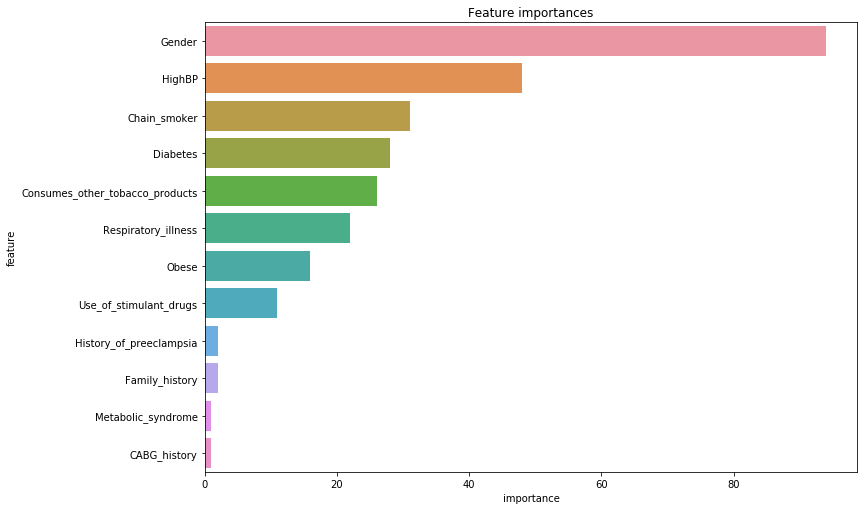

In [55]:
importance = Importance(m_lgb, 'rmse')
importance.plot_feature_importance(top_n=40)

## Predict

In [65]:
from scipy.stats import logistic
pred = m_lgb.predict_proba(df[train_cols])

In [66]:
pred[:,0].min(), pred[:,0].max()

(0.035890398514456745, 0.9996489171167815)

In [71]:
Counter(pred[:,0] > 0.5), Counter(pred[:,1] > 0.5)

(Counter({True: 882, False: 7}), Counter({False: 882, True: 7}))

In [68]:
pred[:,0] + pred[:,1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [62]:
pred = m_lgb.predict(df[train_cols])
pred_2 = m_lgb.predict(test_df[train_cols])
Counter(pred), Counter(pred_2)

(Counter({0: 882, 1: 7}), Counter({0: 379, 1: 3}))

In [59]:
Counter(clf.predict(test_df[train_cols])), Counter(clf.predict(df[train_cols]))

(Counter({0: 358, 1: 24}), Counter({0: 850, 1: 39}))